In [1]:
from datetime import datetime
import os
import re

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from ipynb.fs.defs.functions import prep_data, train, test, break_out_solution
from models.single_head_multi_class.model import SingleHeadMultiClass
from models.multi_head_model.model import MultiHeadModel
from models.dieleman.model import Dieleman

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Load images and labels
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [5]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [6]:
# Create train, test, and validation sets
train_dataset, test_dataset, val_dataset = prep_data(data)

In [7]:
print(
    f"Training input shape: {train_dataset.tensors[0].shape}\nTraining output shape: {train_dataset.tensors[1].shape}"
)

Training input shape: torch.Size([49262, 3, 64, 64])
Training output shape: torch.Size([49262, 37])


## Training

In [21]:
# Instantiate the model
# Feel free to experiment with different models but the SingleHeadSingleClass model has its own script for training
model = SingleHeadMultiClass().to(DEVICE)

In [22]:
# Training Parameters
EPOCHS = 500
BATCH_SIZE = 64
LR = 0.01
GAMMA = 0.99

# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Save path
model_name = "model"
save_path = "models/" + re.sub(r"(?<!^)(?=[A-Z])", "_", model.__class__.__name__).lower() + "/saved/"

In [23]:
print(f"Save path: {save_path}")

Save path: models/multi_head_model/saved/


In [24]:
# Run a single image through the model
model_output = model(train_dataset.tensors[0][0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 37])


In [25]:
# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

11/25 18:24:46 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 17.420678	Test Loss: 17.379246
11/25 18:24:54 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 17.267573	Test Loss: 17.276023
11/25 18:25:02 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 17.227309	Test Loss: 17.235606
11/25 18:25:10 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 17.215113	Test Loss: 17.235244
11/25 18:25:19 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 17.206646	Test Loss: 17.260749
11/25 18:25:27 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 17.194602	Test Loss: 17.225821
11/25 18:25:35 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 17.186441	Test Loss: 17.230714
11/25 18:25:43 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 17.178485	Test Loss: 17.202982
11/25 18:25:51 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 17.169545	Test Loss: 17.165629
11/25 18:26:00 Train Epoch:   10 [49262/49262 (100%)]	Train Loss: 17.165960	Test Loss: 17.168543
11/25 18:26:08 Train Epoch:   

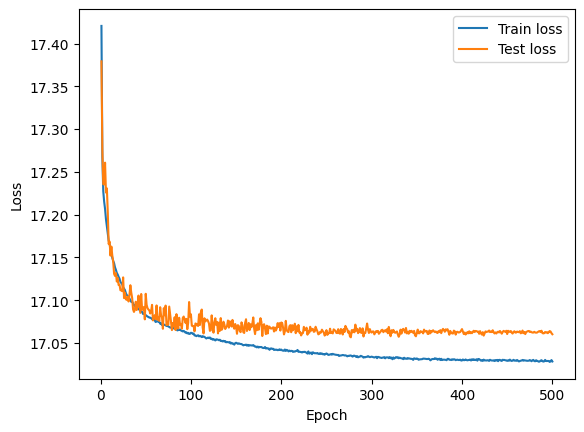

In [27]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

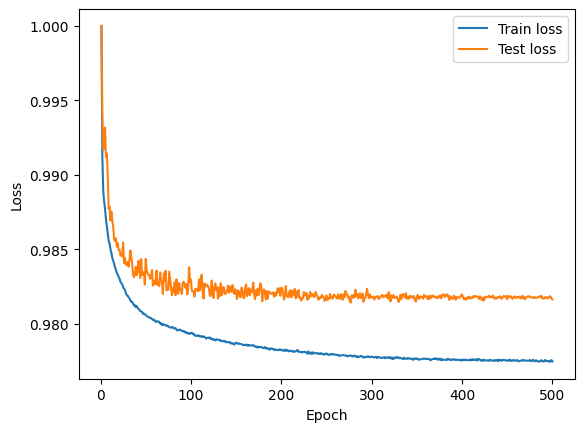

In [28]:
# Plot normalized losses
plt.plot(range(1, EPOCHS + 1), np.array(train_loss) / np.max(train_loss), label="Train loss")
plt.plot(range(1, EPOCHS + 1), np.array(test_loss) / np.max(test_loss), label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
# New model
if model_name is None:
    model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_{model.__class__.__name__}_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

In [30]:
# Save the model
if not os.path.exists(save_path):
    os.makedirs(save_path)
torch.save(model.state_dict(), save_path + model_name + ".pth")
print(f"Model saved as {model_name}")

# Save the losses
np.save(save_path + model_name + "_loss.npy", np.array([train_loss, test_loss]))

Model saved as model


## Evaluation

In [70]:
# Load the model
model_type = Model
model = model_type().to(DEVICE)
model.load_state_dict(torch.load("models/model/saved/sander.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [71]:
# Create a validation data loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the model
criterion = nn.CrossEntropyLoss()
val_loss = test(model, val_loader, criterion)
print(f"Cross Entropy loss: {val_loss}")

criterion = nn.MSELoss()
val_loss = test(model, val_loader, criterion)
print(f"MSE loss: {val_loss}")

Cross Entropy loss: 14.635896849878055
MSE loss: 3.9375146590557293


In [72]:
# Evaluation Metrics
model.eval()

# Eval Size
eval_size = 1000

true_labels = break_out_solution(val_dataset.tensors[1][:eval_size])
pred_labels = break_out_solution(model(val_dataset.tensors[0][:eval_size]))

# Calculate evaluation metrics
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    print(f"Accuracy: {accuracy_score(true_labels[i], pred_labels[i])}")
    print(f"Precision: {precision_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"Recall: {recall_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"F1 Score: {f1_score(true_labels[i], pred_labels[i], average='macro')}")
    print()

Class 1:
Accuracy: 0.825
Precision: 0.5477011494252874
Recall: 0.5484944467297409
F1 Score: 0.5480748685075608

Class 2:
Accuracy: 0.989
Precision: 0.5
Recall: 0.4945
F1 Score: 0.4972347913524384

Class 3:
Accuracy: 0.826
Precision: 0.7275422854785478
Recall: 0.7206250000000001
F1 Score: 0.7239567468778556

Class 4:
Accuracy: 0.896
Precision: 0.6729049698482013
Recall: 0.6657695374800638
F1 Score: 0.6692280291079334

Class 5:
Accuracy: 0.588
Precision: 0.4352921288165519
Recall: 0.4445812981165451
F1 Score: 0.4395868792471088

Class 6:
Accuracy: 0.966
Precision: 0.791740152851264
Recall: 0.7067708333333333
F1 Score: 0.7412008281573499

Class 7:
Accuracy: 0.87
Precision: 0.7834670690434974
Recall: 0.7528007686751526
F1 Score: 0.7661035354478773

Class 8:
Accuracy: 0.447
Precision: 0.40717136609732024
Recall: 0.35125832988064143
F1 Score: 0.3483949055962606

Class 9:
Accuracy: 0.526
Precision: 0.5497908610137713
Recall: 0.5902652388491312
F1 Score: 0.4758782154910803

Class 10:
Accuracy:

c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Class 1:


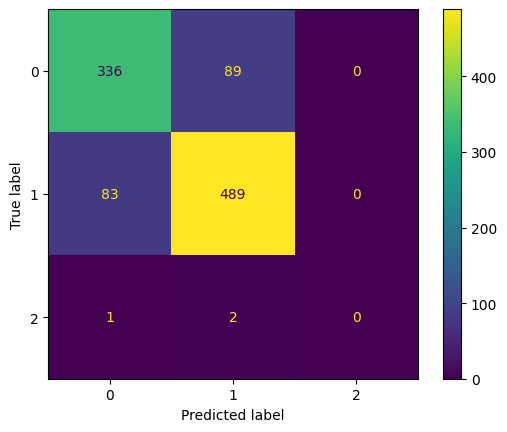


Class 2:


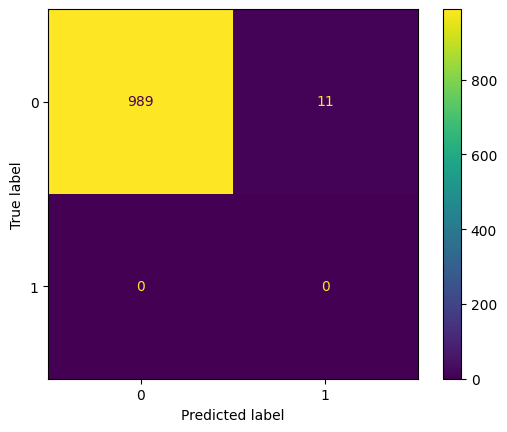


Class 3:


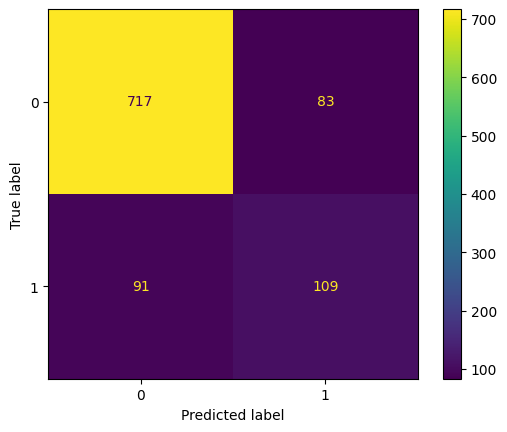


Class 4:


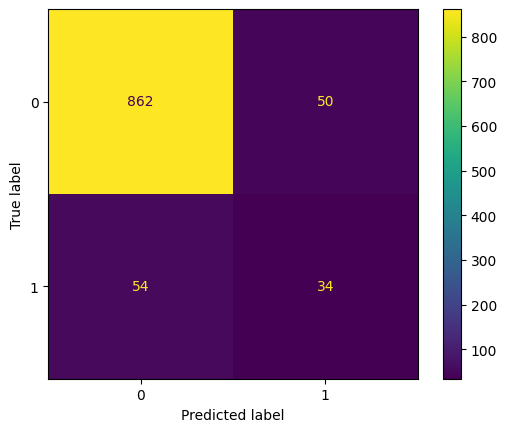


Class 5:


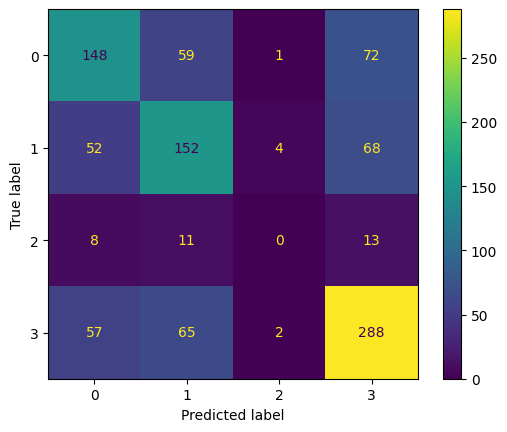


Class 6:


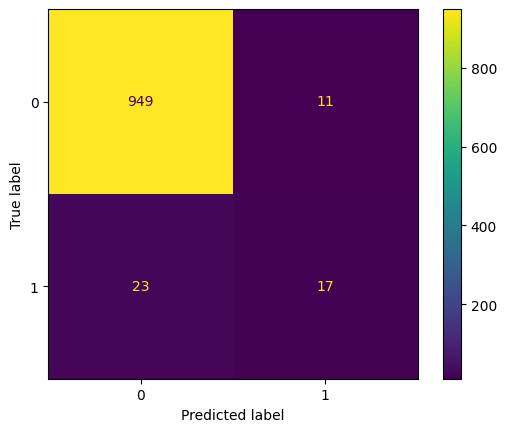


Class 7:


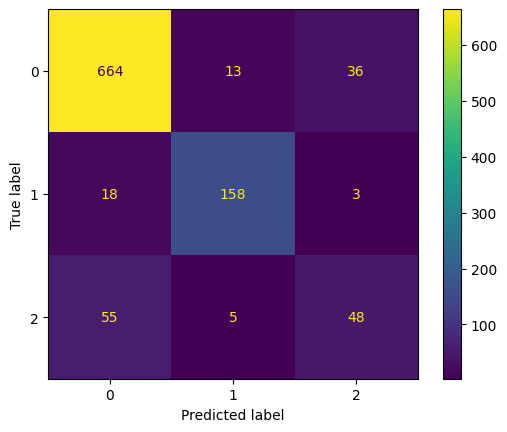


Class 8:


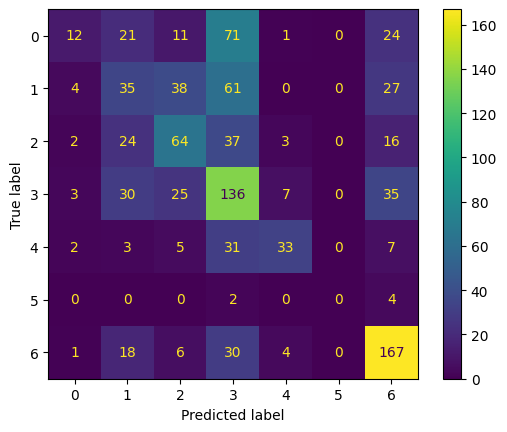


Class 9:


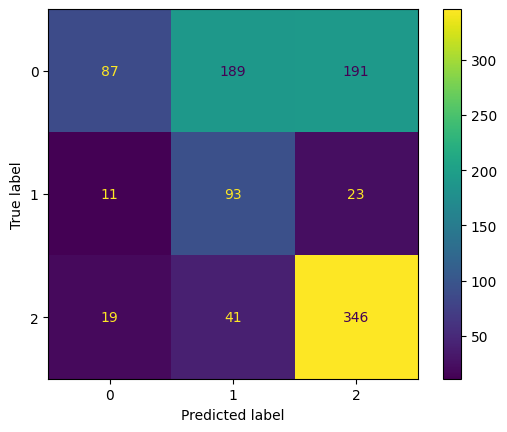


Class 10:


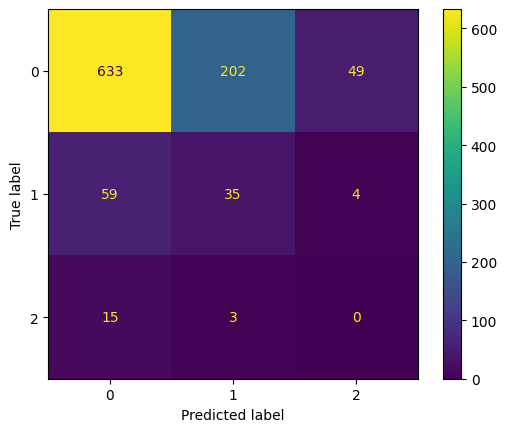


Class 11:


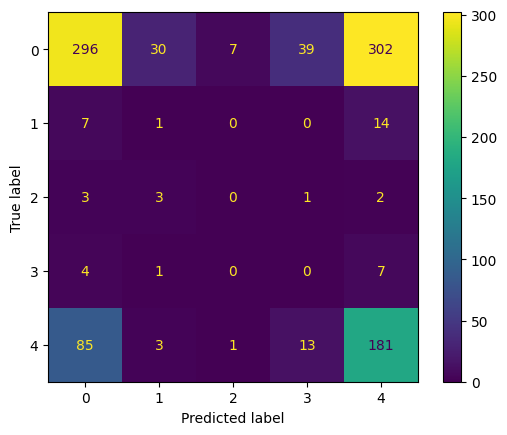

In [73]:
# Display confusion matrices in pretty format
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    cm = confusion_matrix(true_labels[i], pred_labels[i])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print()
